Load the image

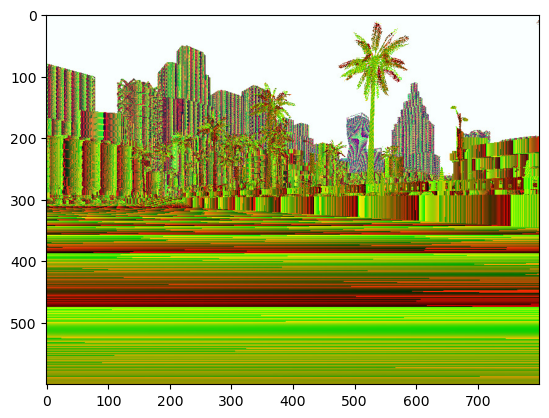

In [47]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D

 
# Read Images
img = mpimg.imread('Rubens test files/Pictures/depth_camera_Sun_Apr_14_20_33_08_2024.png') #to check the picture
img2 = mpimg.imread('Rubens test files/Pictures/instance_camera_Fri_Apr_12_11_27_18_2024.png')
depth_data=plt.imread('Rubens test files/Pictures/depth_camera_Sun_Apr_14_20_33_08_2024.png') #to get the data as an array
segment_data=plt.imread('Rubens test files/Pictures/instance_camera_Fri_Apr_12_11_27_18_2024.png') #to get the data as an array
# Output Images
plt.imshow(img)
#plt.imshow(img2)



Initiate variables

In [48]:
depth_Width=depth_data[1,:,0].size
depth_Height=depth_data[:,1,0].size
print([depth_Height,depth_Width])

segment_Width=round(segment_data[1,:,0].size/3)
segment_Height=round(segment_data[:,1,0].size/3)


converted_depth_data=np.zeros([depth_Width,depth_Height])
segment_data=np.round(segment_data*255)


max_sensor_range= 0.4 #in kilometers
depth_data[0,0,0]

#w2c=camera.get_transform
depth_Height

[600, 800]


600

Calculate costmap


In [49]:
#convert depth units
R=depth_data[:,:,0]
G=depth_data[:,:,1]
B=depth_data[:,:,2]

normalized = ((R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1))*1000

#calculate projection matrix
fov = 90
im_size_x = 800
im_size_y = 600

f  = im_size_x /(2.0 * math.tan(fov * math.pi / 360))
Cx = im_size_x / 2.0
Cy = im_size_y / 2.0

K = np.array([[f, 0, Cx], [0, f, Cy], [0, 0, 1]], dtype=np.float64)
K_inv=np.linalg.inv(K)

#convert the image data to points

[rel_coords,camera_index_mat]=get_point_image(normalized,K_inv,depth_Width,depth_Height)
#camera_index_mat= get_point_world_coordinates(depth_data, K_inv, [[1,0,0],[0,1,0],[0,0,1]], [0,0,0], depth_Height, depth_Width)

print(normalized)

[[3.9058926  3.9058926  3.9058926  ... 3.9058926  3.9058926  3.9058926 ]
 [3.9058926  3.9058926  3.9058926  ... 3.9058926  3.9058926  3.9058926 ]
 [3.9058926  3.9058926  3.9058926  ... 3.9058926  3.9058926  3.9058926 ]
 ...
 [2.25573792 2.25573792 2.25573792 ... 2.25454582 2.25454582 2.25454582]
 [2.29370608 2.29370608 2.29370608 ... 2.29251398 2.29251398 2.29251398]
 [2.28601708 2.28601708 2.28601708 ... 2.28482498 2.28482498 2.28482498]]


In [50]:
#we use np.division to quickly do elementwise matrix division where dividing by 0 equals 1


focal_mat=np.ones_like(rel_coords[:,:,0])
camera_index_mat=rel_coords

c_squared=np.square(focal_mat)+np.square(camera_index_mat[:,:,1])
d=np.power(np.square(camera_index_mat[:,:,0])+c_squared, 0.5*np.ones_like(camera_index_mat[:,:,0]))

#Create a condition to bypass the division incase of zeros
condition= (np.square(camera_index_mat[:,:,0]) + np.square(camera_index_mat[:,:,1]))!=0

#cant put a scalar in np.divide so we use ones
placeholder=np.ones_like(camera_index_mat[:,:,0])

a  = np.divide(placeholder, d, out=np.zeros_like(placeholder), where= condition)

x= a*normalized*camera_index_mat[:,:,0]
y= a*normalized*camera_index_mat[:,:,1]
z= np.sqrt(np.power(normalized,2)-np.power(x,2)-np.power(y,2))



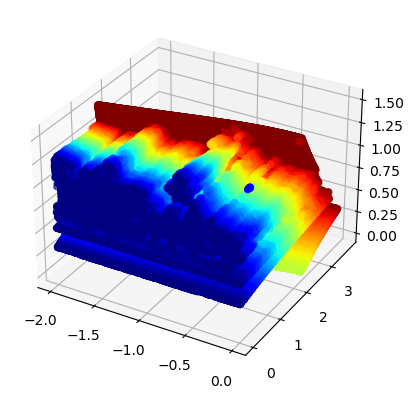

In [51]:
fig=plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(camera_index_mat[:,:,0],z,-camera_index_mat[:,:,1],c=normalized,cmap='jet')
#plt.ylim(0,1)

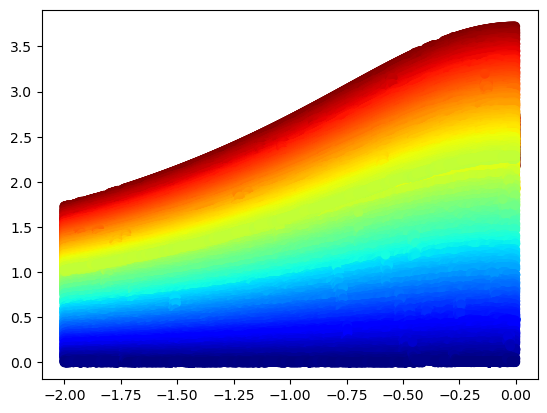

In [52]:
plt.scatter(camera_index_mat[:,:,0],z,c=normalized,cmap='jet')
#plt.xlim(0,-0.005)
#plt.ylim(0,1)


In [53]:
# def get_image_point(loc, K,w2c):
#         # Calculate 2D projection of 3D coordinate

#         # Format the input coordinate (loc is a carla.Position object)
#         point = np.array([loc.x, loc.y, loc.z, 1])
#         # transform to camera coordinates
#         point_camera = np.dot(w2c, point)

#         # New we must change from UE4's coordinate system to an "standard"
#         # (x, y ,z) -> (y, -z, x)
#         # and we remove the fourth componebonent also
#         point_camera = [point_camera[1], -point_camera[2], point_camera[0]]

#         # now project 3D->2D using the camera matrix
#         point_img = np.dot(K, point_camera)
#         # normalize
#         point_img[0] /= point_img[2]
#         point_img[1] /= point_img[2]

#         return point_img[0:2]

def get_point_image(point_img,K_inv,Width,Height):
        loc_mat=np.zeros([Height,Width,3])
        static_projection_matrix=np.zeros([Height,Width,3])
        for i in range(Height):
                for j in range(Width):
                        loc_mat[i,j] = [j-Width/2,i-Height/2,1]
                        static_projection_matrix[i,j]=np.dot(K_inv,loc_mat[i,j])
        return static_projection_matrix , loc_mat
        
        
def get_point_world_coordinates(point_img, K_inv, R, t, Height, Width):
    loc_mat = np.zeros([Height, Width, 3])  # Corrected dimensions
    camera_coordinates = np.zeros([Height, Width, 3])  # Corrected dimensions
    world_coordinates = np.zeros([Height, Width, 3])  # Corrected dimensions
    for i in range(Height):
        for j in range(Width):  # Corrected order of Height and Width
            loc_mat[i, j] = [j, i, 1]  # Corrected order of j and i
            camera_coordinates[i, j] = np.dot(K_inv, loc_mat[i, j]) * point_img[i, j]  
            world_coordinates[i, j] = np.dot(R, camera_coordinates[i, j]) + t
    return world_coordinates